<a href="https://colab.research.google.com/github/rohitritesh/wildfire-early-warning-prediction/blob/main/notebooks/wildfire_training_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Setup — Imports, Configuration, Dataset Path

**What I do here:** I load all libraries used in the notebook, fix a global random seed for reproducibility,  
and set the path to the official dataset file `FPA_FOD_20170508.sqlite`.

In [ ]:
# Importing core utilities and filesystem helpers
import os, json, glob, warnings, sqlite3
from pathlib import Path
from datetime import datetime

# Importing the numeric and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Importing all scikit-learn pieces
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    brier_score_loss,
)
from sklearn.base import clone
from sklearn.inspection import permutation_importance
import joblib

# Setting the path
PATH = Path("FPA_FOD_20170508.sqlite")

# I shall fix a global random seed for reproducibility of results
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Loading, Aggregation, Features, Splits

**What I do here:**
- Load the required columns from the SQLite file.
- Convert discovery dates into real timestamps.
- Aggregate to county × month counts.
- Build a complete 1992–2015 panel, zero-filling missing months.
- Engineer lag/rolling features (last 1 & last 3 months) and define the label.
- Assemble the feature matrix `X` and target `y`.
- Create **time-respecting** splits: Train ≤2010, Val 2011–2012, Test ≥2013.


In [ ]:
# Loading the required columns from the SQLite database
cols = ["FOD_ID","FIRE_YEAR","DISCOVERY_DATE","STAT_CAUSE_DESCR",
        "FIRE_SIZE","FIRE_SIZE_CLASS","LATITUDE","LONGITUDE","STATE","FIPS_NAME"]
with sqlite3.connect(PATH) as con:
    df = pd.read_sql_query(f"SELECT {', '.join(cols)} FROM Fires", con)

# Converting DISCOVERY_DATE to a real calendar timestamp
# I handle both: JDN values are ~2,450,000, whereas Excel serials are << 100,000
d = pd.to_numeric(df["DISCOVERY_DATE"], errors="coerce")
mask_julian = d > 1_000_000
disc = pd.Series(pd.NaT, index=df.index, dtype="datetime64[ns]")
disc.loc[mask_julian] = pd.to_datetime(d.loc[mask_julian], unit="D", origin="julian")
disc.loc[~mask_julian] = pd.to_datetime("1899-12-30") + pd.to_timedelta(d.loc[~mask_julian], unit="D")
df["DISCOVERY_DATE"] = disc

# Extracting YEAR and MONTH from the discovery timestamp
df["YEAR"]  = df["DISCOVERY_DATE"].dt.year.astype("Int64")
df["MONTH"] = df["DISCOVERY_DATE"].dt.month.astype("Int64")

# I now create a region identifier as "STATE | County" (county text comes from FIPS_NAME in this dataset)
df["REGION_ID"] = df["STATE"].astype(str).str.upper() + " | " + df["FIPS_NAME"].astype(str)

# Next I prepare helper flags for aggregation: lightning, human-caused, and large (≥ class D or ≥100 acres)
cause = df["STAT_CAUSE_DESCR"].astype(str).str.lower()
df["IS_LIGHTNING"] = cause.str.contains("lightning", na=False)

human_kw = ["debris","equipment","campfire","smoking","arson","powerline","railroad","children","structure","fireworks","misc"]
df["IS_HUMAN"] = cause.str.contains("|".join(human_kw), na=False) & (~df["IS_LIGHTNING"])

fsc = df["FIRE_SIZE_CLASS"].astype(str).str.upper().str.strip()
df["IS_LARGE"] = fsc.isin(list("DEFG")) | (pd.to_numeric(df["FIRE_SIZE"], errors="coerce") >= 100.0)

# Now I aggregate incidents to county×month totals for multiple signals I will use as features/labels
keys = ["REGION_ID","YEAR","MONTH"]
monthly = (df.dropna(subset=["YEAR","MONTH"])
             .groupby(keys, as_index=False)
             .agg(TOTAL=("FOD_ID","count"),
                  LIGHTNING=("IS_LIGHTNING","sum"),
                  HUMAN=("IS_HUMAN","sum"),
                  LARGE=("IS_LARGE","sum")))

# Building a complete region×month panel for the official span (1992–2015) and left-join counts (zero-fill)
regions = monthly["REGION_ID"].unique()
periods = pd.period_range("1992-01", "2015-12", freq="M")
panel = pd.MultiIndex.from_product([regions, periods], names=["REGION_ID","PERIOD"]).to_frame(index=False)
panel["YEAR"]  = panel["PERIOD"].dt.year.astype(int)
panel["MONTH"] = panel["PERIOD"].dt.month.astype(int)
panel["MONTH_START"] = panel["PERIOD"].dt.to_timestamp(how="start")

data = panel.merge(monthly, on=["REGION_ID","YEAR","MONTH"], how="left")
data[["TOTAL","LIGHTNING","HUMAN","LARGE"]] = data[["TOTAL","LIGHTNING","HUMAN","LARGE"]].fillna(0).astype(int)

# Computing lagged/rolling features per region (shifted by 1 month to avoid peeking into the future)
def add_roll(g: pd.DataFrame) -> pd.DataFrame:
    g = g.sort_values("MONTH_START").copy()
    g["PREV1_TOTAL"] = g["TOTAL"].shift(1)
    g["PREV3_TOTAL"] = g["TOTAL"].shift(1).rolling(3).sum()
    g["PREV3_LIGHT"] = g["LIGHTNING"].shift(1).rolling(3).sum()
    g["PREV3_LARGE"] = g["LARGE"].shift(1).rolling(3).sum()
    g["P_LIGHTNING_3M"] = (g["PREV3_LIGHT"] / g["PREV3_TOTAL"]).replace([np.inf,-np.inf], np.nan)
    g["P_LARGE_3M"]     = (g["PREV3_LARGE"] / g["PREV3_TOTAL"]).replace([np.inf,-np.inf], np.nan)
    return g

data = data.groupby("REGION_ID", group_keys=False).apply(add_roll)

# I define the binary label: did at least one wildfire occur this month in this county?
data["LABEL"] = (data["TOTAL"] > 0).astype(int)

# Dropping the first month per region (where lag features are NaN) and keep the 1992–2015 window
data = data.dropna(subset=["PREV1_TOTAL","PREV3_TOTAL","P_LIGHTNING_3M","P_LARGE_3M"])
data = data[(data["YEAR"] >= 1992) & (data["YEAR"] <= 2015)]

# Assembling the feature matrix (numeric + month categorical to capture seasonality)
features_num = ["PREV1_TOTAL","PREV3_TOTAL","P_LIGHTNING_3M","P_LARGE_3M"]
features_cat = ["MONTH"]  # I will one-hot this later in the pipeline

X = data[features_num + features_cat].copy()
y = data["LABEL"].astype(int).to_numpy()

# Now I create time-respecting splits for training, validation, and testing
train_mask = data["YEAR"] <= 2010
val_mask   = (data["YEAR"] >= 2011) & (data["YEAR"] <= 2012)
test_mask  = data["YEAR"] >= 2013


# Training — Time-Aware Tuning, Calibration, Final Test

**What I do here:**
- Build a preprocessing pipeline (one hot for month, scaling for numeric features).
- Train two models: Logistic Regression and Histogram Gradient Boosting.
- Perform time aware hyperparameter tuning (year based CV on Train years).
- Calibrate probabilities (isotonic on Train+Val) for risk scores.
- Evaluate on held-out Test years (PR-AUC, ROC-AUC, Brier, Precision@Top-10%).
- Save plots, `test_scores_final.csv`, and timestamped model files.

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits


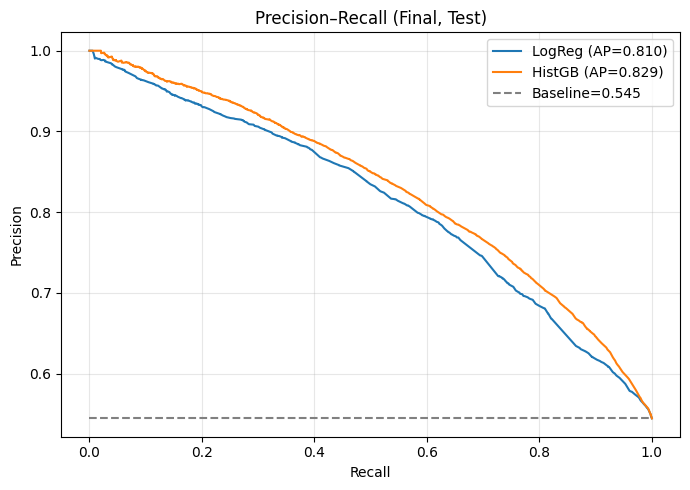

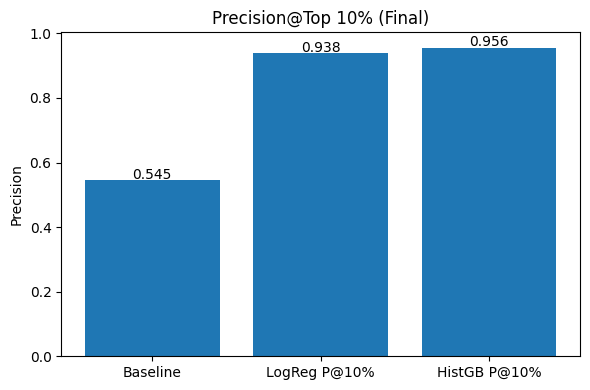

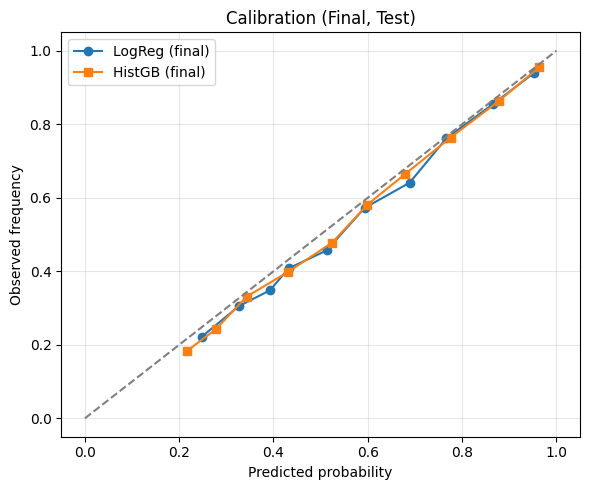

In [ ]:
# Here I define minimal helpers I need for evaluation and plots
def precision_at_frac(y_true, scores, frac=0.10):
    y_true = np.asarray(y_true); scores = np.asarray(scores)
    k = max(1, int(np.ceil(len(y_true)*frac)))
    return y_true[np.argsort(-scores)[:k]].mean()

def calibration_points(y, p, q=10):
    dfc = pd.DataFrame({"y":np.asarray(y), "p":np.asarray(p)})
    dfc["bin"] = pd.qcut(dfc["p"], q=q, duplicates="drop")
    cal = dfc.groupby("bin").agg(mean_p=("p","mean"), obs=("y","mean")).reset_index(drop=True)
    return cal

# Now I build the preprocessing and the two pipelines (Logistic Regression and Histogram Gradient Boosting)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), features_cat),
        ("num", StandardScaler(), features_num),
    ],
    remainder="drop"
)
pipe_lr  = Pipeline([("prep", preprocessor),
                     ("clf", LogisticRegression(max_iter=200, solver="lbfgs",
                                                class_weight="balanced", random_state=RANDOM_STATE))])
pipe_hgb = Pipeline([("prep", preprocessor),
                     ("clf", HistGradientBoostingClassifier(
                         max_depth=6, max_iter=300, learning_rate=0.1, random_state=RANDOM_STATE
                     ))])

# Let us construct year-based CV folds on the TRAIN subset using relative indices (to avoid any indexing issues)
X_tr = X[train_mask].reset_index(drop=True)
y_tr = pd.Series(y[train_mask]).reset_index(drop=True)
years_tr = pd.Series(data.loc[train_mask, "YEAR"].to_numpy()).reset_index(drop=True)

def year_cv_splits_relative(years_series, n_splits=5):
    yr_unique = np.sort(years_series.unique())
    cuts = np.linspace(0, len(yr_unique), n_splits+1, dtype=int)
    year_to_pos = {y: years_series.index[years_series==y].to_numpy() for y in yr_unique}
    splits = []
    for i in range(1, len(cuts)):
        val_years = set(yr_unique[cuts[i-1]:cuts[i]])
        val_pos = np.concatenate([year_to_pos[y] for y in val_years]) if val_years else np.array([], dtype=int)
        all_pos = np.arange(len(years_series))
        tr_pos  = np.setdiff1d(all_pos, val_pos, assume_unique=False)
        if len(tr_pos)>0 and len(val_pos)>0:
            splits.append((tr_pos, val_pos))
    return splits

cv_rel = year_cv_splits_relative(years_tr, n_splits=5)

# Next I set wider hyperparameter spaces (accuracy-first) and run RandomizedSearchCV with time-aware folds
param_lr = {
    "clf__C": np.logspace(-3, 2, 20),
    "clf__penalty": ["l2"],
}
param_hgb = {
    "clf__learning_rate": np.logspace(-2.5, -0.3, 12),
    "clf__max_depth": [3,4,5,6,7,8, None],
    "clf__max_leaf_nodes": [15, 31, 63, 127, None],
    "clf__min_samples_leaf": [10, 20, 50, 100],
    "clf__l2_regularization": np.logspace(-3, 1, 8),
    "clf__max_iter": [200, 300, 500]
}

search_lr  = RandomizedSearchCV(clone(pipe_lr),  param_lr,  n_iter=25, cv=cv_rel,
                                scoring="average_precision", n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
search_hgb = RandomizedSearchCV(clone(pipe_hgb), param_hgb, n_iter=30, cv=cv_rel,
                                scoring="average_precision", n_jobs=-1, random_state=RANDOM_STATE, verbose=1)

search_lr.fit(X_tr, y_tr)
search_hgb.fit(X_tr, y_tr)

# Refitting the best models on Train+Val and calibrate probabilities via isotonic regression (3-fold CV on Train+Val)
trainval_mask = train_mask | val_mask
X_tv, y_tv = X[trainval_mask], y[trainval_mask]
final_lr  = CalibratedClassifierCV(search_lr.best_estimator_,  method="isotonic", cv=3)
final_hgb = CalibratedClassifierCV(search_hgb.best_estimator_, method="isotonic", cv=3)
final_lr.fit(X_tv, y_tv)
final_hgb.fit(X_tv, y_tv)

# Finally I evaluate on the held-out Test years and save plots/CSV
X_te, y_te = X[test_mask], y[test_mask]
p_lr  = final_lr.predict_proba(X_te)[:,1]
p_hgb = final_hgb.predict_proba(X_te)[:,1]
baseline = y_te.mean()

ap_lr  = average_precision_score(y_te, p_lr)
ap_hgb = average_precision_score(y_te, p_hgb)
roc_lr, roc_hgb = roc_auc_score(y_te, p_lr), roc_auc_score(y_te, p_hgb)
brier_lr, brier_hgb = brier_score_loss(y_te, p_lr), brier_score_loss(y_te, p_hgb)
p10_lr, p10_hgb = precision_at_frac(y_te, p_lr, 0.10), precision_at_frac(y_te, p_hgb, 0.10)

os.makedirs("outputs", exist_ok=True)
scores = pd.DataFrame([
    {"Model":"LogReg (final cal)","PR-AUC":ap_lr,"ROC-AUC":roc_lr,"Brier":brier_lr,"Precision@10%":p10_lr},
    {"Model":"HistGB (final cal)","PR-AUC":ap_hgb,"ROC-AUC":roc_hgb,"Brier":brier_hgb,"Precision@10%":p10_hgb},
])
scores.to_csv("outputs/test_scores_final.csv", index=False)

prec_lr, rec_lr, _ = precision_recall_curve(y_te, p_lr)
prec_hg, rec_hg, _ = precision_recall_curve(y_te, p_hgb)

plt.figure(figsize=(7,5))
plt.plot(rec_lr, prec_lr, label=f"LogReg (AP={ap_lr:.3f})")
plt.plot(rec_hg, prec_hg, label=f"HistGB (AP={ap_hgb:.3f})")
plt.hlines(baseline, 0, 1, linestyles="dashed", color="gray", label=f"Baseline={baseline:.3f}")
plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title("Precision–Recall (Final, Test)")
plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("outputs/pr_curve_final.png", dpi=160); plt.show()

plt.figure(figsize=(6,4))
vals = [baseline, p10_lr, p10_hgb]; labels = ["Baseline","LogReg P@10%","HistGB P@10%"]
plt.bar(labels, vals)
for i,v in enumerate(vals): plt.text(i, v+0.005, f"{v:.3f}", ha="center")
plt.ylabel("Precision"); plt.title("Precision@Top 10% (Final)"); plt.tight_layout()
plt.savefig("outputs/precision_at_10_final.png", dpi=160); plt.show()

cal_lr  = calibration_points(y_te, p_lr,  q=10)
cal_hgb = calibration_points(y_te, p_hgb, q=10)
plt.figure(figsize=(6,5))
plt.plot(cal_lr["mean_p"],  cal_lr["obs"],  marker="o", label="LogReg (final)")
plt.plot(cal_hgb["mean_p"], cal_hgb["obs"], marker="s", label="HistGB (final)")
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("Predicted probability"); plt.ylabel("Observed frequency")
plt.title("Calibration (Final, Test)"); plt.legend(); plt.grid(alpha=0.3); plt.tight_layout()
plt.savefig("outputs/calibration_final.png", dpi=160); plt.show()

# Saving timestamped model and a small metadata JSON for exact reproducibility
stamp = datetime.now().strftime("%Y%m%d_%H%M%S")
joblib.dump(final_lr,  f"outputs/model_logreg_final_{stamp}.joblib")
joblib.dump(final_hgb, f"outputs/model_histgb_final_{stamp}.joblib")
with open(f"outputs/model_metadata_{stamp}.json","w") as f:
    json.dump({
        "timestamp": stamp,
        "best_params_logreg": search_lr.best_params_,
        "best_params_histgb": search_hgb.best_params_,
        "features_num": features_num,
        "features_cat": features_cat,
        "train_years": [int(data.loc[train_mask,"YEAR"].min()), int(data.loc[train_mask,"YEAR"].max())],
        "val_years":   [2011, 2012],
        "test_years":  [int(data.loc[test_mask,"YEAR"].min()),  int(data.loc[test_mask,"YEAR"].max())],
        "random_state": RANDOM_STATE
    }, f, indent=2)


# Demonstration — Scoring a Given Month & Single-County Query

**What I do here:**
- Load the best calibrated model (or reuse it from memory).
- Score **all counties** for a chosen year–month (e.g. August 2015).
- Save a ranked CSV of counties by risk; print the top-K table.
- Provide a tiny helper to query a specific county (state + county name).

**How to change the month:** Edit the `year` and `month` variables and re-run this cell.

In [ ]:
# Let us load the calibrated final model (I prefer the tuned Histogram Gradient Boosting); if it is already in memory, I reuse it
import glob, joblib
try:
    model = final_hgb
except NameError:
    latest = sorted(glob.glob("outputs/model_histgb_final_*.joblib"))[-1]
    model = joblib.load(latest)

# Choose a year–month to score, I can change these two numbers to test any period in my data (1992–2015)
year, month = 2015, 8

# Computing risks for all counties in the chosen month, ranking them, displaying top-K, and saving the full table to CSV
import numpy as np, pandas as pd
mask = (data["YEAR"]==year) & (data["MONTH"]==month)
Xm   = X[mask]
ids  = data.loc[mask, "REGION_ID"].reset_index(drop=True)
risk = model.predict_proba(Xm)[:, 1]
month_df = pd.DataFrame({
    "REGION_ID": ids,
    "YEAR": year,
    "MONTH": month,
    "RISK": risk
})
# I split REGION_ID into STATE and COUNTY just for readability in the table I will show
split_df = month_df["REGION_ID"].str.split(" | ", n=1, expand=True)
month_df["STATE"]  = split_df[0]
month_df["COUNTY"] = split_df[1]
month_df = month_df.sort_values("RISK", ascending=False).reset_index(drop=True)

top_k = 20
display(month_df.loc[:top_k-1, ["STATE","COUNTY","YEAR","MONTH","RISK"]])

out_path = f"outputs/preds_{year}_{month:02d}.csv"
month_df.to_csv(out_path, index=False)
print(f"Saved ranked predictions: {out_path}")

# Providing a tiny helper to query a single county by state + county name for the same (year, month)
def predict_county(state_abbr: str, county_name: str, year: int, month: int):
    rid = f"{state_abbr.upper()} | {county_name}"
    subset = month_df[month_df["REGION_ID"]==rid]
    if subset.empty:
        print(f"County not found for '{rid}' in {year}-{month:02d}. Check spelling/capitalisation as in REGION_ID.")
        return
    rank = int(subset.index[0]) + 1
    total = len(month_df)
    pct   = 100.0 * (1 - (rank-1)/total)
    prob  = float(subset["RISK"].iloc[0])
    print(f"{rid} in {year}-{month:02d} → risk={prob:.3f}, rank {rank}/{total} (≈{pct:.1f}th percentile)")

# Let us run an example single-county query (You can change the county/state to my choice)
predict_county("CA", "Los Angeles", year, month)


,STATE,COUNTY,YEAR,MONTH,RISK
0,WA,| None,2015,8,0.999461
1,MT,| None,2015,8,0.999461
2,CA,| None,2015,8,0.999461
3,CA,| Fresno,2015,8,0.999461
4,AZ,| None,2015,8,0.999461
5,CA,| Riverside,2015,8,0.999461
6,CA,| Shasta,2015,8,0.998741
7,CA,| El Dorado,2015,8,0.998741
8,CA,| Lassen,2015,8,0.998741
9,OR,| Douglas,2015,8,0.998741


Saved ranked predictions: outputs/preds_2015_08.csv
CA | Los Angeles in 2015-08 → risk=0.989, rank 57/1638 (≈96.6th percentile)
